# Research question: How much of the variation in the hosptials thrombolysis rate can be attributed to the difference in the hospital processes, and to its different patient mix?

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In this notebook we will use the model from notebook 03a (fitted a single model to all of the data, no test set)) and focus on understanding the amount of variance in hospital IVT that is captured in feature SHAP values and SHAP main effects (using linear regressions and multiple linear regressions).

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values and SHAP main effect and the hospital IVT rate.

## Model and data

Using the XGBoost model trained on all of the data (no test set used) from notebook 03a_xgb_combined_shap_key_features.ipynb. The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims
* Using XGBoost model fitted on all the data (no test set) using 10 features
* Using SHAP values previously calculated
* Understand the amount of variance in hospital IVT that is captured in feature SHAP values and SHAP main effects (using regressions and multiple regressions)
* Divide the features into two groups: patient features and hosptial features

## Observations
KP FINISH THIS
* Using mean SHAP values,....
* In notebook 03e we look at calculating subset SHAP values and fit a multiple regression on these.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap

from scipy import stats
from sklearn import linear_model

import os
import pickle

# .floor and .ceil
import math 

# So can take deep copy
import copy

from os.path import exists
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03e'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

The model used in this notebook is fitted using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X_data = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X_data.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X_data['Stroke team'], prefix = 'team')
X_data = pd.concat([X_data, X_hosp], axis=1)
X_data.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X_data)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X_data)
y_pred_proba = model.predict_proba(X_data)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Load from pickle (calculated in notebook 03a).

In [13]:
%%time

# Load SHAP explainer model used to estimate SHAP values
filename = f'./output/03a_{model_text}_shap_explainer_object.p'
with open(filename, 'rb') as filehandler:
    explainer = pickle.load(filehandler)
    
# Load SHAP values extended (using the explainer model)
filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
with open(filename, 'rb') as filehandler:
    shap_values_extended = pickle.load(filehandler)

CPU times: user 468 ms, sys: 1.39 s, total: 1.85 s
Wall time: 315 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

### How does the SHAP value for patient features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and mean SHAP value for each feature (for those patients that attend the hospital).

In [15]:
# Get SHAP values
shap_values = shap_values_extended.values

# List of unique stroke team names
unique_stroketeams_list = list(set(data["Stroke team"]))

In [16]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [17]:
# Create dataframe with hospital as index, column per feature, containing
# mean SHAP value for feature for patients that attend that hospital

# Initialise list
mean_values_hosp = []

for h in unique_stroketeams_list:
#    calculate mean SHAP for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_values_hosp.append(np.mean(shap_values[mask],axis=0))

df_mean_shap_values_per_hosp = pd.DataFrame(data=mean_values_hosp, 
                                              index=unique_stroketeams_list,
                                              columns=feature_names_ohe)

In [18]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
WTBXP2683L,-0.568094,-1.078075,-0.208221,0.089512,-0.069973,-0.032465,-0.062210,0.007235,-0.016900,0.001249,...,-0.007705,0.003072,0.003131,-0.003374,0.000407,0.000394,-0.001227,0.002571,-0.002146,0.003375
UJETD9177J,0.167886,-1.063151,0.000333,0.026769,-0.037765,0.003270,-0.057988,0.032087,-0.016600,0.001931,...,-0.007739,0.002493,0.002944,-0.004493,0.000517,0.000338,-0.001434,0.002586,-0.002013,0.003106
PAOUI8935Z,-0.083003,-0.557687,-0.626537,-0.055085,0.087441,-0.027163,-0.028661,0.039505,-0.000064,0.004112,...,-0.008002,0.002420,0.003079,-0.004806,0.000475,0.000287,-0.001336,0.002103,-0.001596,0.002141
OKVRY7006H,-0.222107,-1.114639,-0.201348,-0.193234,0.025925,-0.015762,-0.025530,0.015381,0.031714,0.001141,...,-0.009270,0.003209,0.002801,-0.003548,0.000379,0.000505,-0.001756,0.002229,-0.002142,0.002776
ATDID5461S,-1.448628,-1.208378,-0.029776,-0.009178,-0.067311,-0.041711,0.031067,0.024344,-0.079060,0.000735,...,-0.009202,0.003423,0.003374,-0.001539,0.000242,0.000306,-0.001677,0.002796,-0.002455,0.004638
GKONI0110I,-0.331089,-0.984204,-0.350943,-0.223345,-0.003442,-0.006485,-0.032734,0.007957,0.005109,0.000771,...,-0.009162,0.003399,0.002939,-0.002822,0.000367,0.000477,-0.001508,0.002221,-0.001969,0.003290
QTELJ8888W,-0.844260,-1.109753,0.141786,0.178139,0.111471,-0.072499,-0.075971,0.021328,-0.004606,0.000826,...,-0.008864,0.003362,0.003214,-0.001893,0.000349,0.000374,-0.001794,0.003026,-0.001974,0.004031
QQUVD2066Z,0.136372,-0.980927,-0.131322,0.193710,-0.059096,-0.078017,-0.043302,0.027973,-0.029430,0.001890,...,-0.006836,0.002609,0.003206,-0.004560,0.000569,0.000358,-0.001619,0.002432,-0.002055,0.002883
SQGXB9559U,-0.423818,-1.178880,-0.112912,0.101720,0.050269,-0.114378,-0.044331,-0.021431,0.007254,0.000957,...,-0.008459,0.003088,0.002996,-0.003065,0.000409,0.000469,-0.001878,0.002373,-0.002196,0.003287
HZMLX7970T,0.140441,-1.483570,0.146931,-0.098753,0.011653,-0.026290,0.012879,-0.013134,-0.025377,0.002085,...,-0.008405,0.002455,0.002838,-0.004275,0.000459,0.000365,-0.001877,0.002468,-0.002182,0.002984


In [19]:
# Join IVT rate with admissions per hosptial
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(hosp_ivt_rate)

In [20]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis
WTBXP2683L,-0.568094,-1.078075,-0.208221,0.089512,-0.069973,-0.032465,-0.062210,0.007235,-0.016900,0.001249,...,0.003072,0.003131,-0.003374,0.000407,0.000394,-0.001227,0.002571,-0.002146,0.003375,0.266428
UJETD9177J,0.167886,-1.063151,0.000333,0.026769,-0.037765,0.003270,-0.057988,0.032087,-0.016600,0.001931,...,0.002493,0.002944,-0.004493,0.000517,0.000338,-0.001434,0.002586,-0.002013,0.003106,0.382199
PAOUI8935Z,-0.083003,-0.557687,-0.626537,-0.055085,0.087441,-0.027163,-0.028661,0.039505,-0.000064,0.004112,...,0.002420,0.003079,-0.004806,0.000475,0.000287,-0.001336,0.002103,-0.001596,0.002141,0.365000
OKVRY7006H,-0.222107,-1.114639,-0.201348,-0.193234,0.025925,-0.015762,-0.025530,0.015381,0.031714,0.001141,...,0.003209,0.002801,-0.003548,0.000379,0.000505,-0.001756,0.002229,-0.002142,0.002776,0.237500
ATDID5461S,-1.448628,-1.208378,-0.029776,-0.009178,-0.067311,-0.041711,0.031067,0.024344,-0.079060,0.000735,...,0.003423,0.003374,-0.001539,0.000242,0.000306,-0.001677,0.002796,-0.002455,0.004638,0.240385
GKONI0110I,-0.331089,-0.984204,-0.350943,-0.223345,-0.003442,-0.006485,-0.032734,0.007957,0.005109,0.000771,...,0.003399,0.002939,-0.002822,0.000367,0.000477,-0.001508,0.002221,-0.001969,0.003290,0.389153
QTELJ8888W,-0.844260,-1.109753,0.141786,0.178139,0.111471,-0.072499,-0.075971,0.021328,-0.004606,0.000826,...,0.003362,0.003214,-0.001893,0.000349,0.000374,-0.001794,0.003026,-0.001974,0.004031,0.336449
QQUVD2066Z,0.136372,-0.980927,-0.131322,0.193710,-0.059096,-0.078017,-0.043302,0.027973,-0.029430,0.001890,...,0.002609,0.003206,-0.004560,0.000569,0.000358,-0.001619,0.002432,-0.002055,0.002883,0.456376
SQGXB9559U,-0.423818,-1.178880,-0.112912,0.101720,0.050269,-0.114378,-0.044331,-0.021431,0.007254,0.000957,...,0.003088,0.002996,-0.003065,0.000409,0.000469,-0.001878,0.002373,-0.002196,0.003287,0.242206
HZMLX7970T,0.140441,-1.483570,0.146931,-0.098753,0.011653,-0.026290,0.012879,-0.013134,-0.025377,0.002085,...,0.002455,0.002838,-0.004275,0.000459,0.000365,-0.001877,0.002468,-0.002182,0.002984,0.194286


### Regression between hospital IVT rate and SHAP value for features (mean for those instances that attend the hospital)

In [21]:
def plot_regressions(df_hosp_mean, features, title):
    n_features = len(features)
    cols = 3
    rows = np.int((n_features / cols) + 1)
    count = 1

    fig = plt.figure(figsize=((6*cols),(6*rows)))
    
    for feat in features: 
        # Setup data for chart
        x = df_hosp_mean[feat]
        y = df_hosp_mean['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
        ax = fig.add_subplot(rows,cols,count)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{title} {feat} "
                      f"\n(mean of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

        (xmin, xmax) = ax.get_xlim()
        (ymin, ymax) = ax.get_ylim()

        plt.grid()

        # Add  text
        f = (str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

    
        x_placement = xmin + 0.05*(xmax - xmin)
        y_placement = ymax - 0.15*(ymax - ymin)
        ax.text(x_placement, y_placement, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

        count+=1
        
    plt.show()
    
    return()

In [22]:
def fit_and_plot_multiple_regression(df_hosp_mean, features, x_label_text="", 
                                     ax=None):
    X = df_hosp_mean[features]
    y = df_hosp_mean['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, 
                                columns=["coeff"])
    print(df_reg_coeff)

    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred_line = intercept + (y * slope)
    
    # Create scatter plot with regression line
    if ax is None: 
        ax = plt.gca()

    ax.scatter(y_pred, y, color = 'k', marker="o", s=20)
    ax.plot (y_pred_line, y, color = 'k', linestyle='--', linewidth=1)

    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()
    axis_min = min(xmin, ymin)
    axis_max = max(xmax, ymax)
    
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_xlabel(f'Hospital thrombolysis rate (predicted{x_label_text})')
    ax.set_ylabel('Hospital thrombolysis rate (observed)')

    plt.grid()

    # Add  text
    f = (str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    
    x_placement = axis_min + 0.05*(axis_max - axis_min)
    y_placement = axis_max - 0.15*(axis_max - axis_min)
    ax.text(x_placement, y_placement, text,
             bbox=dict(facecolor='white', edgecolor='white'))

    return(ax)

Add in the mean SHAP value for the hospital feature (already calculated in notebook 03c)

In [23]:
filename = (f'./output/03c_{model_text}'
            f'_hospital_shap_vs_ivt_rate.csv')
df_hosp_shap = pd.read_csv(filename)
df_hosp_shap = df_hosp_shap.set_index("hospital")

In [24]:
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(df_hosp_shap, rsuffix="h_")
df_mean_shap_values_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis,shap_mean_sv,Thrombolysish_,shap_mean_me
WTBXP2683L,-0.568094,-1.078075,-0.208221,0.089512,-0.069973,-0.032465,-0.062210,0.007235,-0.016900,0.001249,...,0.000407,0.000394,-0.001227,0.002571,-0.002146,0.003375,0.266428,-0.254392,0.266428,-0.246171
UJETD9177J,0.167886,-1.063151,0.000333,0.026769,-0.037765,0.003270,-0.057988,0.032087,-0.016600,0.001931,...,0.000517,0.000338,-0.001434,0.002586,-0.002013,0.003106,0.382199,0.216033,0.382199,0.187677
PAOUI8935Z,-0.083003,-0.557687,-0.626537,-0.055085,0.087441,-0.027163,-0.028661,0.039505,-0.000064,0.004112,...,0.000475,0.000287,-0.001336,0.002103,-0.001596,0.002141,0.365000,0.614194,0.365000,0.503691
OKVRY7006H,-0.222107,-1.114639,-0.201348,-0.193234,0.025925,-0.015762,-0.025530,0.015381,0.031714,0.001141,...,0.000379,0.000505,-0.001756,0.002229,-0.002142,0.002776,0.237500,-0.318980,0.237500,-0.342782
ATDID5461S,-1.448628,-1.208378,-0.029776,-0.009178,-0.067311,-0.041711,0.031067,0.024344,-0.079060,0.000735,...,0.000242,0.000306,-0.001677,0.002796,-0.002455,0.004638,0.240385,0.182610,0.240385,0.212440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LFPMM4706C,-2.009026,-0.569263,-0.806824,-0.186225,-0.034029,-0.058948,-0.271025,-0.004678,-0.048369,0.000896,...,0.000263,0.000329,-0.001404,0.002249,-0.002081,0.003239,0.062500,-1.271484,0.062500,-1.148681
OQYTM8444L,-0.183703,-0.862155,0.048012,0.046188,0.088399,-0.018978,-0.124379,-0.073665,0.008024,0.002041,...,0.000502,0.000317,-0.001721,0.002667,-0.001832,0.003228,0.364017,-0.098254,0.364017,-0.113462
TXHRP7672C,-0.277461,-1.028139,-0.154141,-0.100427,0.074880,-0.070113,-0.047869,-0.046435,-0.045866,0.001188,...,0.000396,0.000427,-0.001589,0.002442,-0.001888,0.003149,0.272512,-0.137471,0.272512,-0.161671
IAZKG9244A,-0.407538,-1.170300,-0.157970,-0.166374,0.061785,-0.044921,-0.039230,-0.005187,-0.021641,0.001131,...,0.000371,0.000445,-0.001792,0.002400,-0.001867,0.003122,0.380759,0.818965,0.380759,0.801195


Regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital)



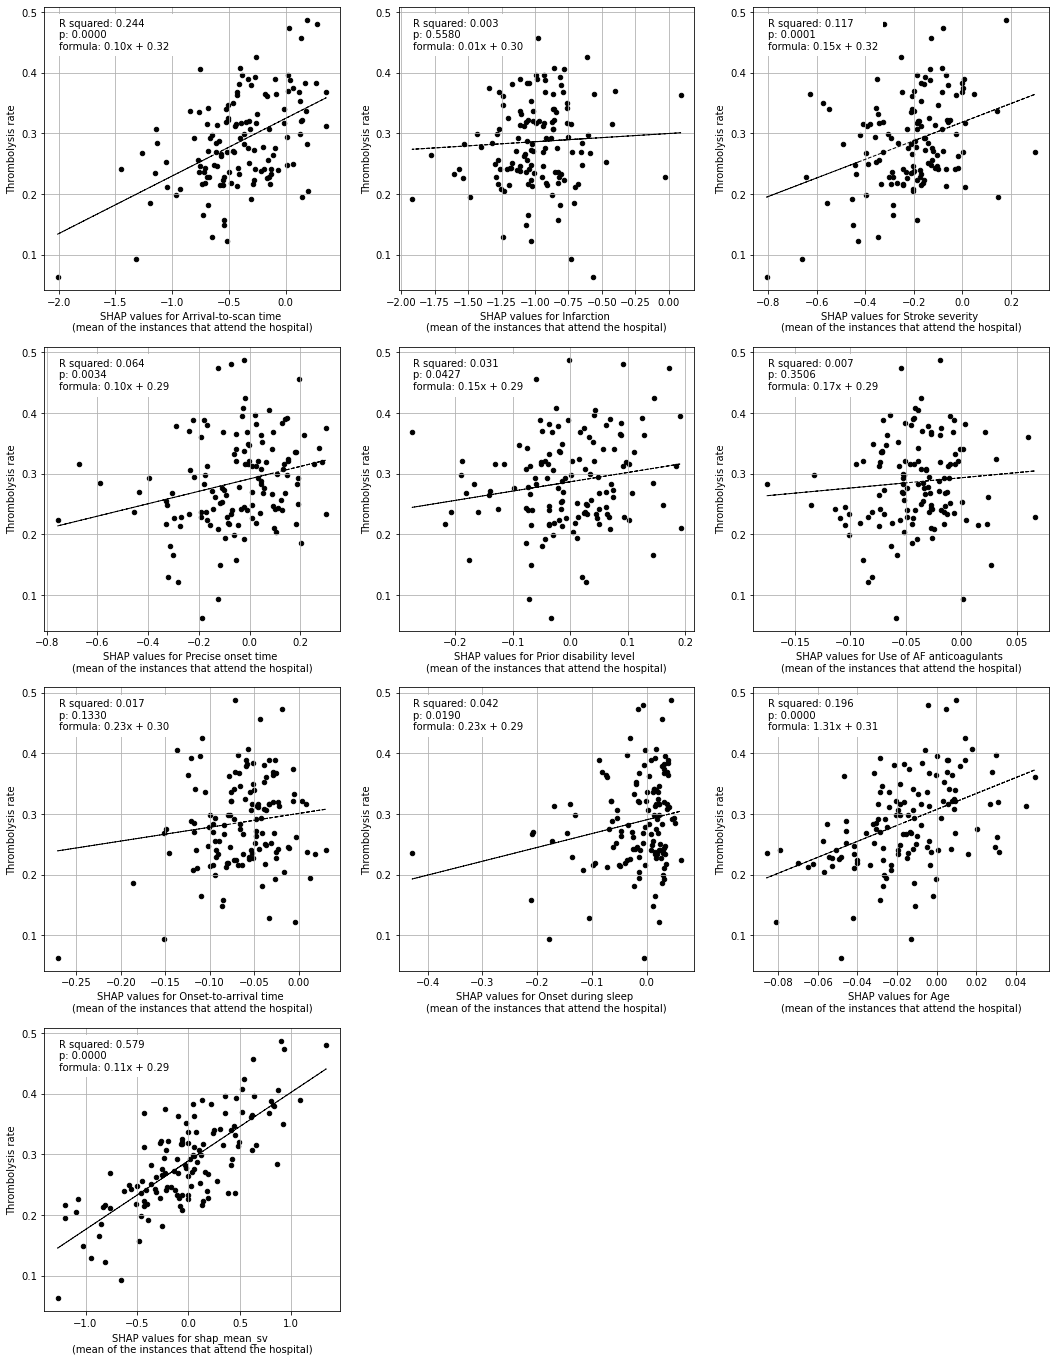

In [25]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age', 'shap_mean_sv']

title = "SHAP values for"
df = df_mean_shap_values_per_hosp

print("Regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital)")
print()
plot_regressions(df, features_to_plot, title)
print ()

### Multiple regression on all features vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for all features (mean for those instances that attend the hospital)

                             coeff
Arrival-to-scan time      0.066249
Infarction                0.034880
Stroke severity           0.089651
Precise onset time        0.116825
Prior disability level    0.090232
Use of AF anticoagulants  0.129920
Onset-to-arrival time    -0.098246
Onset during sleep        0.068122
Age                       0.178001
shap_mean_sv              0.109368



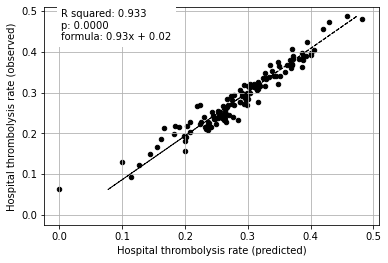

In [26]:
print("Multiple regression between hosptial IVT rate and SHAP value for all "
      "features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on features (excluding attended hosptial) vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital), excluding attended hospital SHAP

                             coeff
Arrival-to-scan time      0.079886
Infarction                0.063246
Stroke severity           0.111067
Precise onset time        0.046224
Prior disability level    0.050308
Use of AF anticoagulants  0.036244
Onset-to-arrival time    -0.088946
Onset during sleep        0.074848
Age                       0.785148



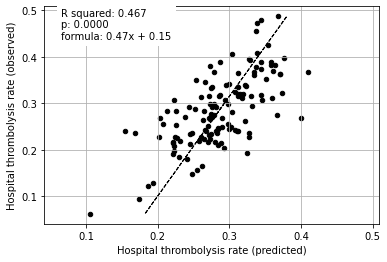

In [27]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital), excluding "
      "attended hospital SHAP")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on just patient characteristics vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for just patient features (mean for those instances that attend the hospital)

                             coeff
Infarction                0.041041
Stroke severity           0.136061
Precise onset time        0.060148
Prior disability level    0.047838
Use of AF anticoagulants -0.058462
Onset-to-arrival time     0.071181
Onset during sleep        0.111865
Age                       1.062042



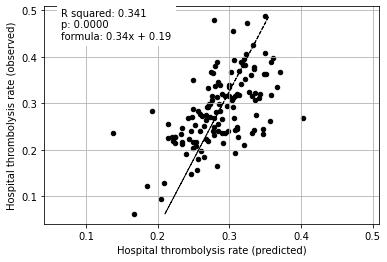

In [28]:
features_to_plot = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP value for just "
      "patient features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on just hospital processes vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital)

                         coeff
Arrival-to-scan time  0.079993
shap_mean_sv          0.106429



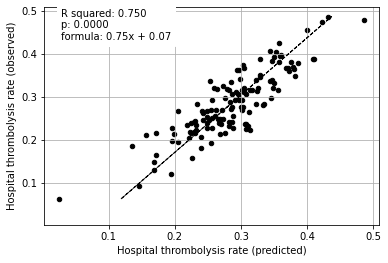

In [29]:
features_to_plot = ['Arrival-to-scan time','shap_mean_sv']

print("Multiple regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

Is there a correlation between IVT rate and proportion ischemeic?

In [30]:
# Calculate IVT rate per hosptial
hosp_isch_rate = data.groupby(by=["Stroke team"]).mean()["Infarction"]
hosp_isch_ivt_rate = pd.concat([hosp_isch_rate, hosp_ivt_rate], axis=1)
hosp_isch_ivt_rate = hosp_isch_ivt_rate.rename(columns={"Infarction":"Proportion infarction"})
hosp_isch_ivt_rate

,Proportion infarction,Thrombolysis
Stroke team,,
AGNOF1041H,0.846154,0.352468
AKCGO9726K,0.916667,0.369748
AOBTM3098N,0.866667,0.218803
APXEE8191H,0.783972,0.226481
ATDID5461S,0.817308,0.240385
...,...,...
YPKYH1768F,0.854890,0.246057
YQMZV4284N,0.859574,0.236170
ZBVSO0975W,0.821759,0.250000


Regression between hosptial IVT rate and proportion of patients with infarction



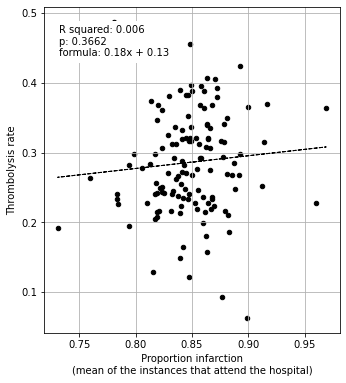

In [31]:
features_to_plot = ['Proportion infarction']

title = ""
df = hosp_isch_ivt_rate

print("Regression between hosptial IVT rate and proportion of patients with "
      "infarction")
print()
plot_regressions(df, features_to_plot, title)
print ()

## Repeat using SHAP main effect

Read in SHAP interactions from notebook 03b

In [32]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
# Load SHAP interaction
with open(filename, 'rb') as filehandler:
    shap_interaction = pickle.load(filehandler)

shap_interaction.shape

CPU times: user 62.9 ms, sys: 3.52 s, total: 3.58 s
Wall time: 6.59 s


(88792, 141, 141)

Get main effect for each feature for each patient

In [33]:
# Initialise list
shap_main_effects = []

# For each patient
for i in range(shap_interaction.shape[0]):
# Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    shap_main_effects.append(main_effects)

# Put main effects in dataframe with features as column title
df_hosp_shap_main_effects = pd.DataFrame(shap_main_effects, 
                                         columns=feature_names_ohe)

# Only keep the hospital one-hot encoded feature for the attended hospital

# Initialise list
shap_of_team_attended = []

# For each patient
for i in range(shap_interaction.shape[0]):
    shap_of_team_attended.append(
        df_hosp_shap_main_effects[f"team_{data['Stroke team'].loc[i]}"].loc[i])

# Store the SHAP values for the hospital attended
df_hosp_shap_main_effects["Stroke team"] = shap_of_team_attended

# remove thrombolysis
feature_names_keep = feature_names[0:-1]
df_hosp_shap_main_effects = df_hosp_shap_main_effects[feature_names_keep]

In [34]:
df_hosp_shap_main_effects.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
0,0.676277,0.338386,0.862582,0.430773,0.322120,-0.187852,0.135322,-0.441546,0.042960,0.231744
1,0.447184,0.339734,0.297246,0.434184,0.331810,-0.580359,0.138708,0.165874,0.048222,0.235642
2,-2.979032,0.321163,-1.694299,0.420702,0.379625,-1.192582,0.148083,0.001259,0.039560,0.125615
3,0.336959,-8.517138,0.747195,0.435908,0.358994,0.977001,0.161105,0.071381,0.043983,0.042129
4,0.847006,0.340107,0.851986,0.437559,0.336050,0.070702,0.143654,0.160698,0.044551,0.053406


In [35]:
# Create dataframe with hospital as index, column per feature, containing
# mean SHAP main effect for feature for patients that attend that hospital

# Initialise list
mean_shap_main_effect_hosp = []

# For each hosptial
for h in unique_stroketeams_list:
#    calcualte mean shap main effect for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_shap_main_effect_hosp.append(np.mean(df_hosp_shap_main_effects[mask],axis=0))

# Create DataFrame
df_mean_shap_main_effect_per_hosp = pd.DataFrame(data=mean_shap_main_effect_hosp, 
                                                   index=unique_stroketeams_list,
                                                   columns=feature_names_keep)

In [36]:
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
WTBXP2683L,-0.566392,-1.094181,-0.244383,0.099864,-0.073954,-0.246171,-0.035296,-0.031246,0.013016,-0.010531
UJETD9177J,0.163283,-1.013434,0.018959,0.010821,-0.029124,0.187677,0.004912,-0.043813,0.035046,-0.019228
PAOUI8935Z,-0.226706,-0.540729,-0.649567,-0.098058,0.093960,0.503691,-0.023444,-0.017860,0.038761,-0.000621
OKVRY7006H,-0.197097,-1.096246,-0.211280,-0.225956,0.031772,-0.342782,-0.018292,0.028240,0.018985,0.026400
ATDID5461S,-1.552424,-1.274140,-0.070140,-0.031144,-0.083791,0.212440,-0.037784,0.030321,0.030951,-0.064359
...,...,...,...,...,...,...,...,...,...,...
LFPMM4706C,-2.104762,-0.561571,-0.880854,-0.222696,-0.050473,-1.148681,-0.053124,-0.144069,-0.000484,-0.039264
OQYTM8444L,-0.175588,-0.893046,0.039105,0.047279,0.057429,-0.113462,-0.032074,-0.107137,-0.051401,-0.007509
TXHRP7672C,-0.315854,-1.064904,-0.172556,-0.109573,0.039314,-0.161671,-0.077274,-0.044357,-0.034483,-0.066013
IAZKG9244A,-0.405435,-1.167679,-0.145506,-0.249526,0.055055,0.801195,-0.061838,-0.011698,0.001581,-0.027919


Add thrombolysis rate

In [37]:
df_mean_shap_main_effect_per_hosp = (
                        df_mean_shap_main_effect_per_hosp.join(hosp_ivt_rate))
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
WTBXP2683L,-0.566392,-1.094181,-0.244383,0.099864,-0.073954,-0.246171,-0.035296,-0.031246,0.013016,-0.010531,0.266428
UJETD9177J,0.163283,-1.013434,0.018959,0.010821,-0.029124,0.187677,0.004912,-0.043813,0.035046,-0.019228,0.382199
PAOUI8935Z,-0.226706,-0.540729,-0.649567,-0.098058,0.093960,0.503691,-0.023444,-0.017860,0.038761,-0.000621,0.365000
OKVRY7006H,-0.197097,-1.096246,-0.211280,-0.225956,0.031772,-0.342782,-0.018292,0.028240,0.018985,0.026400,0.237500
ATDID5461S,-1.552424,-1.274140,-0.070140,-0.031144,-0.083791,0.212440,-0.037784,0.030321,0.030951,-0.064359,0.240385
...,...,...,...,...,...,...,...,...,...,...,...
LFPMM4706C,-2.104762,-0.561571,-0.880854,-0.222696,-0.050473,-1.148681,-0.053124,-0.144069,-0.000484,-0.039264,0.062500
OQYTM8444L,-0.175588,-0.893046,0.039105,0.047279,0.057429,-0.113462,-0.032074,-0.107137,-0.051401,-0.007509,0.364017
TXHRP7672C,-0.315854,-1.064904,-0.172556,-0.109573,0.039314,-0.161671,-0.077274,-0.044357,-0.034483,-0.066013,0.272512
IAZKG9244A,-0.405435,-1.167679,-0.145506,-0.249526,0.055055,0.801195,-0.061838,-0.011698,0.001581,-0.027919,0.380759


Regression between hosptial IVT rate and SHAP main effect for features (mean for those instances that attend the hospital)



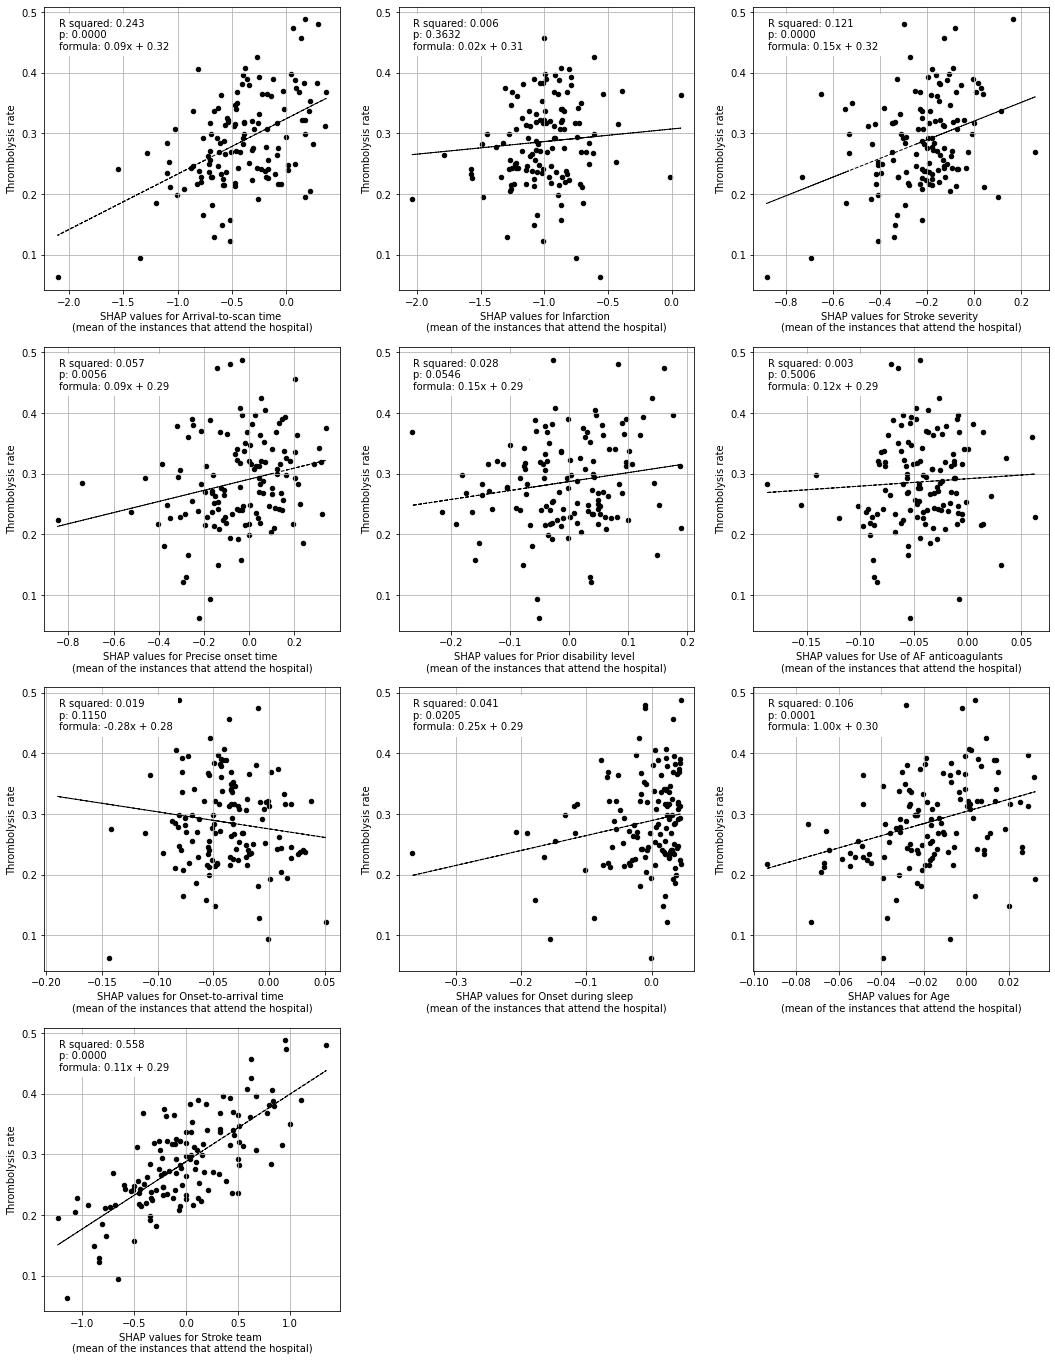

In [38]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age', 'Stroke team']

title = "SHAP values for"
df = df_mean_shap_main_effect_per_hosp

print("Regression between hosptial IVT rate and SHAP main effect for features "
      "(mean for those instances that attend the hospital)")
print()
plot_regressions(df, features_to_plot, title)
print ()

### Multiple regression on all features vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for all features (mean for those instances that attend the hospital)

                             coeff
Arrival-to-scan time      0.057707
Infarction                0.039323
Stroke severity           0.096126
Precise onset time        0.120059
Prior disability level    0.114161
Use of AF anticoagulants  0.125367
Onset-to-arrival time    -0.038941
Onset during sleep        0.119999
Age                       0.063427
Stroke team               0.113671



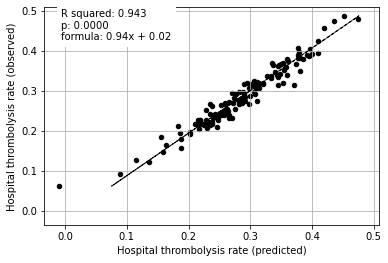

In [39]:
print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "all features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on features (excluding attended hosptial) vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for features (mean for those instances that attend the hospital), excluding attended hospital SHAP main effect

                             coeff
Arrival-to-scan time      0.077741
Infarction                0.066426
Stroke severity           0.106478
Precise onset time        0.038122
Prior disability level    0.038869
Use of AF anticoagulants  0.078658
Onset-to-arrival time    -0.277672
Onset during sleep        0.139637
Age                       0.667224



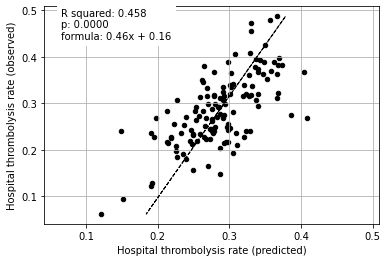

In [40]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "features (mean for those instances that attend the hospital), excluding "
      "attended hospital SHAP main effect")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on just patient characteristics vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for just patient features (mean for those instances that attend the hospital)

                             coeff
Infarction                0.044203
Stroke severity           0.161031
Precise onset time        0.052356
Prior disability level    0.041763
Use of AF anticoagulants  0.004635
Onset-to-arrival time    -0.332927
Onset during sleep        0.216030
Age                       0.793499



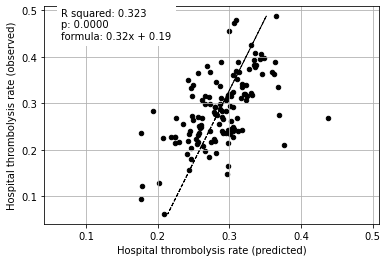

In [41]:
features_to_plot = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "just patient features (mean for those instances that attend the "
      "hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

### Multiple regression on just hospital processes vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for  hospital features (mean for those instances that attend the hospital)

                         coeff
Arrival-to-scan time  0.078443
Stroke team           0.104766



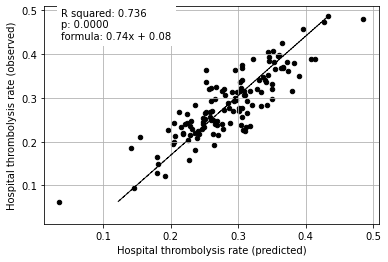

In [42]:
features_to_plot = ['Arrival-to-scan time','Stroke team']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      " hospital features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
print()
plt.show()
print ()

We can improve the division of patient features and hosptial features. 

Since we're splitting the features into two groups (hospital features, and patient features) to fit a multiple regression, we can improve what we include in the SHAP value.

So far we have looked at the two extremes: SHAP values (includes all interactions) and main effect (no interactions).

Next let's only include the SHAP interactions for the features that are in the same regression. So only the main effect and the interactions that are with the other features in the multiple regression. Let's call this the *subset* SHAP value.

This will exclude any SHAP interactions that are between the hostpial features and patient features - and will remove any leakage of patient information into hospital SHAP, and hospital information into patient SHAP.


Do this in the next notebook: 03f_xgb_subset_shap_value_regressions_on_hospital_ivt_rate.ipynb

Calculate subset SHAP values and fit a multiple regression on these.